## Load the data

In [248]:
import pandas as pd

df_base = pd.read_csv('data/data_clean.csv')
df_base = df_base.drop(columns='Disasters_N')
df_base

,Year,Country,Agriculture_%,co2,Energy,Prevalence of overweight (% of adults),Urban Pop Anual Growth_%,Average_Temperature
0,1980,Afghanistan,58.34,1.756,NaN,7.3,-0.405638,14.887333
1,1981,Afghanistan,58.34,1.978,NaN,7.6,-7.791890,14.860083
...,...,...,...,...,...,...,...,...
8983,2019,Zimbabwe,41.88,10.949,1200.0,NaN,1.992351,NaN
8984,2020,Zimbabwe,41.88,10.531,1200.0,NaN,2.130421,NaN


In [249]:
df_base = df_base.set_index('Country')

In [250]:
from sklearn.impute import KNNImputer

imputer = KNNImputer()
data = imputer.fit_transform(df_base)

df_base_impna = pd.DataFrame(data, columns=df_base.columns, index=df_base.index)
df_base = df_base_impna.copy()

La energia comienza a partir del 2000. Por tanto, la descartamos.

In [251]:
df_base = df_base.query('Year > 1998').copy()

## Model for one sample 

### Select one year

In [252]:
df_year = df_base.query('Year == 2012').drop(columns=['Year'])

### Scale the data

In [253]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_year)

### PCA

In [254]:
from sklearn.decomposition import PCA

pca = PCA()
data_pca = pca.fit_transform(data_scaled)

cols_pca = [f'PC{i+1}' for i in range(pca.n_components_)]
df_pca = pd.DataFrame(data_pca, columns=cols_pca, index=df_year.index)

In [255]:
df_year

,Agriculture_%,co2,Energy,Prevalence of overweight (% of adults),Urban Pop Anual Growth_%,Average_Temperature
Country,,,,,,
Afghanistan,58.12,10.219,0.144,20.5,4.958981,14.481583
Albania,43.84,4.668,97.000,54.8,1.848379,13.768250
...,...,...,...,...,...,...
Zambia,32.06,4.166,86.576,25.6,4.555770,21.697750
Zimbabwe,41.88,7.883,1200.000,36.6,1.272568,21.521333


In [256]:
df_pca

,PC1,PC2,PC3,PC4,PC5,PC6
Country,,,,,,
Afghanistan,1.544737,1.280364,-1.194668,-0.137057,0.901593,0.748970
Albania,-0.637267,-0.070600,-0.681473,0.138935,0.051735,0.452329
...,...,...,...,...,...,...
Zambia,1.752320,0.285120,-0.178020,0.171612,0.741475,0.414638
Zimbabwe,0.231414,0.053874,-0.364397,-0.164519,0.243522,-0.644271


In [257]:
df_weights = pd.DataFrame(pca.components_.T, columns=df_pca.columns, index=df_year.columns)
df_stl = df_weights.style.applymap(lambda v: f'background-color: darkorange; opacity: {int(v*100)+40}%;')
df_stl

,PC1,PC2,PC3,PC4,PC5,PC6
Agriculture_%,-0.043005,0.529262,-0.608826,-0.386502,-0.443238,-0.038982
co2,-0.086472,0.594666,0.294418,0.677730,-0.263436,-0.153286
Energy,-0.198128,0.376633,0.662854,-0.579846,0.046248,0.202874
Prevalence of overweight (% of adults),-0.521284,-0.380209,0.058417,0.103340,-0.612553,0.440898
Urban Pop Anual Growth_%,0.628859,0.132868,-0.011607,0.117829,-0.055549,0.754837
Average_Temperature,0.533121,-0.249376,0.315795,-0.174685,-0.594724,-0.411893


In [258]:
with open('df_weights.pkl', 'wb') as f:
    pickle.dump(df_weights, f)

In [259]:
with open('df_weights.pkl', 'rb') as f:
    df_weights = pickle.load(f)

In [260]:
df_stl

,PC1,PC2,PC3,PC4,PC5,PC6
Agriculture_%,-0.043005,0.529262,-0.608826,-0.386502,-0.443238,-0.038982
co2,-0.086472,0.594666,0.294418,0.677730,-0.263436,-0.153286
Energy,-0.198128,0.376633,0.662854,-0.579846,0.046248,0.202874
Prevalence of overweight (% of adults),-0.521284,-0.380209,0.058417,0.103340,-0.612553,0.440898
Urban Pop Anual Growth_%,0.628859,0.132868,-0.011607,0.117829,-0.055549,0.754837
Average_Temperature,0.533121,-0.249376,0.315795,-0.174685,-0.594724,-0.411893


In [261]:
pca.explained_variance_ratio_.cumsum()

array([0.28284397, 0.50472618, 0.67523128, 0.81036451, 0.91457292,
       1.        ])

## Model for multiple years 

In [262]:
from sklearn.cluster import KMeans

In [263]:
df_years = df_base.groupby('Year')

In [264]:
dic_pcas = {}

### Select one year
for label, df_year in df_years:

    df_year = df_year.drop(columns='Year')

    ### Scale the data
    data_scaled = scaler.transform(df_year)

    # Model KMeans
    model_km = KMeans(n_clusters=3)
    clusters = model_km.fit_predict(X=data_scaled)
    clusters = [f'Group {i}' for i in clusters]

    ### PCA
    data_pca = pca.transform(data_scaled)
    cols_pca = [f'PC{i+1}' for i in range(pca.n_components_)]
    df_pca = pd.DataFrame(data_pca, columns=cols_pca, index=df_year.index)

    pca_expvr = pca.explained_variance_ratio_
    ranking = df_pca.multiply(other=pca_expvr).sum(axis=1).sort_values(ascending=False).index
    
    df_pca.insert(0, 'Cluster', clusters)
    df_pca.insert(0, 'Year', str(int(label)))

    dic_pcas[str(int(label))] = df_pca.reindex(ranking, axis=0)

In [265]:
year1 = '1999'

In [266]:
year2 = '2000'

In [267]:
pc = 'PC1'

In [268]:
df_year1_pc = dic_pcas[year1][[pc, 'Year']].reset_index()

df_year2_pc = dic_pcas[year2][[pc, 'Year']]
order_year2 = df_year2_pc.index
df_year2_pc = df_year2_pc.reset_index()

dff = pd.concat([df_year1_pc, df_year2_pc])

dff['Change %'] = dff.groupby('Country').PC1.pct_change()*100
dff_pivot = dff.pivot_table(index='Country', columns='Year', values=['PC1', 'Change %'])
dff_pivot = dff_pivot.reindex(order_year2)

dff_pivot.style.background_gradient('Greens', subset=['PC1']).bar(subset=['Change %'])

In [273]:
dff_pivot

Change %       PC1          
Year                    2000      1999      2000
Country                                         
Equatorial Guinea   3.728020  3.315677  3.439286
China             -30.507765  0.353472  0.245636
...                      ...       ...       ...
Tuvalu              3.639806 -1.950218 -2.021202
Nauru               3.145902 -1.480389 -1.526961

[226 rows x 3 columns]

In [278]:
dff_pivot = dff_pivot.sort_values((pc, year2), ascending=False)

In [ ]:
d

In [269]:
import pickle

In [270]:
with open('dic_pca.pkl', 'wb') as f:
    pickle.dump(dic_pcas, f)

In [64]:
import plotly.express as px

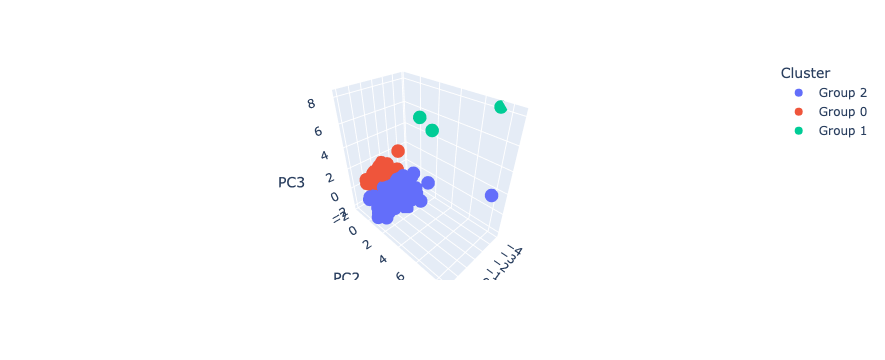

In [65]:
px.scatter_3d(data_frame=df_pca, x='PC1', y='PC2',
              z='PC3', color='Cluster', hover_name=df_pca.index)

In [66]:
dic_pca

{2020.0:                   Cluster       PC1       PC2       PC3       PC4       PC5  \
 Country                                                                       
 China             Group 2 -2.323477  8.550094  2.815438  9.467654 -3.547804   
 India             Group 0 -3.943139  7.237542  8.185024 -5.366606 -0.207958   
 ...                   ...       ...       ...       ...       ...       ...   
 American Samoa    Group 1 -2.238088 -1.277383  0.132891  0.297485  0.096567   
 Marshall Islands  Group 1 -2.280438 -1.238113 -0.257605 -0.275595 -1.666190   
 
                        PC6  
 Country                     
 China            -1.161108  
 India             3.197677  
 ...                    ...  
 American Samoa   -1.100614  
 Marshall Islands -1.178084  
 
 [227 rows x 7 columns]}

In [67]:
with open('dic_pca.pkl', 'rb') as f:
    dic_pcas = pickle.load(f)

In [ ]:
dic_pca